In [89]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 2.5]
import numpy as np
import scipy
import scipy.io
import pandas as pd
from numpy import genfromtxt
from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import *
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import cv2
from torchmeta.modules import *
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from torchmeta.utils.data import *
import random
import maml
from maml.metalearners import ModelAgnosticMetaLearning
from torchmeta.utils.data import MetaDataset
import math


In [2]:
%load_ext autoreload
%autoreload 2

## README.txt

This folder contains the preliminary dataset for the coursework for R250: Applications of ML to Psychiatry.

COBRE_demographics.csv includes a list of subject ids, labels, sex and age information.
Labels: -1 for a healthy control subject, 1 for a patient with schizophrenia
Sex: -1 for male, 1 for female
PANSS total: these are symptom scores (from the Positive and Negative Syndrome Scale). Note controls do not have symptom data. Symptoms are also missing for 2 patients.

COBRE_cortical_thickness.csv includes cortical thickness measurements for all subjects, for 308 cortical brain regions.

COBRE_fmri_connectivity.mat is a Matlab file with connectivity data for all subjects. Subjects are listed in the same order as the demographics file above.
Note that not only 293 out of 308 brain regions have fmri data available (due to incomplete fMRI coverage of the brain- some regions have signal drop out). These 293 regions are listed in the file COBRE_fmri_regions.csv.
Also note that the values from the connectivity matrices are provided in vector format. To transform back to a connectivity matrix, you need to reshape the vectors.
E.g. in Matlab, use the command: matrix = reshape(connectivity_data(ind,:),[293,293])
where ind is an integer between 1 and 148 denoting the subject you are interested in. To check you have reshaped the matrix correctly, try plotting it- it should be a symmetric matrix with 1s on the diagonal.

COBRE_fmri_connectivity.csv- as above but saved as a .csv file.

COBRE_fmri_regions.csv- list of regions with fMRI data available (see above).

In [3]:
demographics = pd.read_csv("./data/COBRE_demographics.csv", sep=r'\s*,\s*', engine="python")
fmri_connectivity = pd.read_csv("./data/COBRE_fmri_connectivity.csv", sep=r'\s*,\s*', engine="python")
cortical_thickness = pd.read_csv("./data/COBRE_cortical_thickness.csv", sep=r'\s*,\s*', engine="python")
fmri_regions = pd.read_csv("./data/COBRE_fmri_regions.csv", sep=r'\s*,\s*', engine="python")
fmri_connectivity_np = genfromtxt("./data/COBRE_fmri_connectivity.csv", delimiter=',')

In [4]:
available_regions = np.concatenate((np.array([0]), fmri_regions['Region_no'].to_numpy() + 1))

# Quick data investigation

[17, 13, 14, 10]
[20, 6, 6, 12]
[6, 6, 6, 3]
[1, 4, 1, 2]


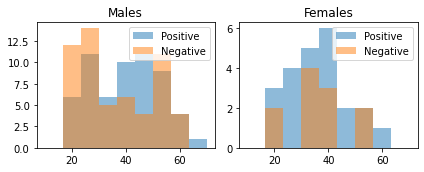

In [5]:
ages = demographics["age"]

c_pos_m = [0, 0, 0, 0]
c_con_m = [0, 0, 0, 0]

c_pos_f = [0, 0, 0, 0]
c_con_f = [0, 0, 0, 0]
m_ages_pos = []
f_ages_pos = []

m_ages_neg = []
f_ages_neg = []

for i in range(len(demographics["age"])):
    
    t_pos_m = 0
    t_neg_m = 0
    
    t_pos_f = 0
    t_neg_f = 0
    
    if(demographics["labels"][i] == -1):
        if(demographics["sex"][i] == -1):
            m_ages_pos.append(demographics["age"][i])
            t_pos_m = 1
        else:
            f_ages_pos.append(demographics["age"][i])
            t_pos_f = 1
    else:
        if(demographics["sex"][i] == -1):
            m_ages_neg.append(demographics["age"][i])
            t_neg_m = 1
        else:
            f_ages_neg.append(demographics["age"][i])
            t_neg_f = 1
            
    for j in range(4):
        min_age = (j+2)*10
        max_age = min_age + 10
        if(demographics["age"][i] > min_age and demographics["age"][i] < max_age):
            c_pos_m[j] += t_pos_m
            c_con_m[j] += t_neg_m
            c_pos_f[j] += t_pos_f
            c_con_f[j] += t_neg_f
         
            
print(c_pos_m)
print(c_con_m)

print(c_pos_f)
print(c_con_f)

plt.subplot(1, 2, 1)
bins = np.linspace(10, 70, 10)
plt.hist(m_ages_pos, bins, alpha=0.5, label='Positive')
plt.hist(m_ages_neg, bins, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.title("Males")

plt.subplot(1, 2, 2)
bins = np.linspace(10, 70, 10)
plt.title("Females")
plt.hist(f_ages_pos, bins, alpha=0.5, label='Positive')
plt.hist(f_ages_neg, bins, alpha=0.5, label='Negative')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [4]:
subject_to_data = {} # Each item to a tuple (Age, True / False, fMRI_connectivity_matrix, cortical_thickness)
for p in range(len(demographics["SubjectID"])):
    patient = demographics.iloc[p]
    p_fmri = fmri_connectivity_np[p, :]
    if(patient["sex"] != -1):
        continue 
    subject_to_data[patient["SubjectID"]] = [patient["age"], (patient["labels"] == -1), np.reshape(p_fmri, (293, 293)), np.zeros(308)]
    
for p in range(len(cortical_thickness["Subject_ID"])):
    patient = cortical_thickness.iloc[p]
    if(patient["Subject_ID"] not in subject_to_data):
        continue
    
    subject_to_data[patient["Subject_ID"]][3] = patient.to_numpy()[2:]



In [27]:
# BALANCE DATA
import random
subject_to_data2 = {}
for i in range(4):
    # Per category
    min_age = (i+2)*10
    for j in range(2):
        pos = j
        ls = []
        for pid, l in subject_to_data.items():
            if(l[0] < min_age or l[0] > (min_age + 10)):
                continue
            if(l[1] != pos):
                continue
            ls.append(l)
            subject_to_data2[pid] = l
        
        if len(ls) < 15:
            while(len(ls) < 15):
                r = random.randint(0, len(ls)-1)
                to_duplicate = ls[r]
                r2 = random.randint(0, 100000000)
                subject_to_data2[r2] = to_duplicate
                ls.append(to_duplicate)
        print(len(ls))
subject_to_data = subject_to_data2

26
17
15
15
16
16
16
15


In [16]:
X = []
y = []
s = 128
for pid, l in subject_to_data.items():
    x_temp = cv2.resize(l[2]*255, dsize=(s, s), interpolation=cv2.INTER_CUBIC)
    X.append(x_temp)
    y.append(int(l[1]))

X = np.array(X).astype(np.double)
y = np.array(y).astype(np.double)
    
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

train_x = train_x.reshape(train_x.shape[0], 1, s, s)
train_x  = torch.from_numpy(train_x)
val_x = val_x.reshape(val_x.shape[0], 1, s, s)
val_x  = torch.from_numpy(val_x)

val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)



(102, 128, 128) (102,)
(12, 128, 128) (12,)


In [149]:
def get_splits(l):
    train_x2 = np.zeros(((math.ceil(.2* l[:, 1].shape[0])), l[:, 1][0].shape[0], l[:, 1][0].shape[1]))
    for i, item in enumerate(l[:, 1]):
        if(i >= train_x2.shape[0]):
            break
        train_x2[i, :, :] = item
    
    train_y2 = np.array(l[:train_x2.shape[0], 0], dtype=np.int16)
    train_x2 = np.expand_dims(train_x2, axis=1)

    
    test_x2 = np.zeros((math.ceil(.8* l[:, 1].shape[0]), l[:, 1][0].shape[0], l[:, 1][0].shape[1]))
    c = 0
    for i, item in reversed(list(enumerate(l[:, 1]))):
        if(c >= test_x2.shape[0]):
            break
        test_x2[c, :, :] = item
        c+=1
    test_y2 = np.array(l[-1* test_x2.shape[0]:, 0], dtype=np.int16)
    test_x2 = np.expand_dims(test_x2, axis=1)
    
    return (train_x2, train_y2, test_x2, test_y2)



d = {}
s = 100
for pid, l in subject_to_data.items():
    x_temp = cv2.resize(l[2]*255, dsize=(s, s), interpolation=cv2.INTER_CUBIC)
    cat = (int(l[0] / 10)) - 2
    if cat not in [0, 1, 2, 3]:
        continue
    
    if cat not in d:
        d[cat] = []
    
    d[cat].append([int(l[1]), x_temp])
 
e = {}
heldout = {}
for cat in d:
    x = len(np.array(d[cat]))
    g = np.array(d[cat])
    np.random.shuffle(g)
    z = math.floor(.3 * x)
    l2 = g[z:, :]
    l5 = g[:z, :]
    
    e[cat] = get_splits(l2)
    heldout[cat] = get_splits(l5)
    
    


<ipython-input-149-ee2b94a8d555>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = len(np.array(d[cat]))
<ipython-input-149-ee2b94a8d555>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  g = np.array(d[cat])


## Classification

In [29]:
# Without doing k-means classification

def get_results(subject_to_data, min_age, max_age):
    X = []
    y = []
    kf = KFold(n_splits=10, shuffle=False)
    for pid, l in subject_to_data.items():
        if(l[0] >= min_age and l[0] < max_age):
            X.append(l[2].flatten())
            #X.append(l[3])
            y.append(int(l[1]))
    
    X = np.array(X)
    y = np.array(y)
    kf.get_n_splits(X)
    
    acc = []
    pres = []
    rec = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        p = precision_score(y_test, y_pred)
        if(p!=0):
            pres.append(p)
        r = recall_score(y_test, y_pred)
        if(r != 0):
            rec.append(r)
    
    
    return (np.mean(np.array(acc)), np.std(np.array(acc)), np.mean(np.array(pres)), np.std(np.array(pres)), np.mean(np.array(rec)), np.std(np.array(rec)))
    #print(confusion_matrix(y_test,y_pred))
    #print(classification_report(y_test,y_pred))

print("All")    
print(get_results(subject_to_data, 0, 100))

print("20 to 30")    
print(get_results(subject_to_data, 20, 30))

print("30 to 40")    
print(get_results(subject_to_data, 30, 40))

print("40 to 50")    
print(get_results(subject_to_data, 40, 50))

print("50 to 60")    
print(get_results(subject_to_data, 50, 60))


All


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6442307692307693, 0.15936289369522788, 0.6891534391534392, 0.3026529025624358, 0.7061253561253562, 0.20977097893894475)
20 to 30


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

(0.5416666666666667, 0.23935677693908453, 0.9166666666666666, 0.14433756729740646, 0.6041666666666666, 0.2724311839712921)
30 to 40


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 

(0.8333333333333333, 0.223606797749979, 1.0, 0.0, 0.8666666666666666, 0.16329931618554522)
40 to 50


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due 

(0.4833333333333333, 0.36094013046179524, 1.0, 0.0, 0.7, 0.2449489742783178)
50 to 60


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.775, 0.25833333333333336, 1.0, 0.0, 0.888888888888889, 0.24845199749997662)


In [30]:
## K-means clustering
def k_means_get_results(subject_to_data, min_age, max_age):
    X = []
    y = []
    for pid, l in subject_to_data.items():
        if(l[0] >= min_age and l[0] < max_age):
            #X.append(l[2].flatten())
            X.append(l[3])
            y.append(int(l[1]))

    X = np.array(X)
    y = np.array(y)
    
    kmeans = GaussianMixture(n_components=5, covariance_type='diag').fit(X)
    y_kmeans = kmeans.predict(X)
    b2 = kmeans.predict_proba(X)
    
    kf = KFold(n_splits=10, shuffle=False)
    kf.get_n_splits(b2)
    
    acc = []
    pres = []
    rec = []
    
    for train_index, test_index in kf.split(b2):
        X_train, X_test = b2[train_index], b2[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        p = precision_score(y_test, y_pred)
        if(p!=0):
            pres.append(p)
        r = recall_score(y_test, y_pred)
        if(r != 0):
            rec.append(r)
    
    
    return (np.mean(np.array(acc)), np.std(np.array(acc)), np.mean(np.array(pres)), np.std(np.array(pres)), np.mean(np.array(rec)), np.std(np.array(rec)))
    

In [42]:
print("All")    
print(k_means_get_results(subject_to_data, 20, 60))

print("20 to 30")    
print(k_means_get_results(subject_to_data, 20, 30))

print("30 to 40")    
print(k_means_get_results(subject_to_data, 30, 40))

print("40 to 50")    
print(k_means_get_results(subject_to_data, 40, 50))

print("50 to 60")    
print(k_means_get_results(subject_to_data, 50, 60))

All
(0.6336363636363636, 0.15892458838514711, 0.5876984126984127, 0.22865167517722335, 0.8605555555555556, 0.12510366072152296)
20 to 30
(0.575, 0.31721443851123804, 0.9, 0.20000000000000004, 0.6, 0.22607766610417562)
30 to 40
(0.6, 0.37416573867739417, 0.8333333333333334, 0.23570226039551584, 1.0, 0.0)
40 to 50
(0.75, 0.25, 0.9375, 0.16535945694153692, 0.875, 0.21650635094610965)
50 to 60
(0.5, 0.39440531887330776, 1.0, 0.0, 0.75, 0.25)


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being

In [31]:
#t-SNE before k-means clustering
def tsne_k_means_get_results(subject_to_data, min_age, max_age):
    X = []
    y = []
    for pid, l in subject_to_data.items():
        if(l[0] >= min_age and l[0] < max_age):
            X.append(l[2].flatten())
            #X.append(l[3])
            y.append(int(l[1]))

    X = np.array(X)
    y = np.array(y)
    
    X = TSNE(n_components=2).fit_transform(X)
    
    kmeans = GaussianMixture(n_components=5, covariance_type='diag').fit(X)
    y_kmeans = kmeans.predict(X)
    b2 = kmeans.predict_proba(X)
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(b2)
    
    acc = []
    pres = []
    rec = []
    
    for train_index, test_index in kf.split(b2):
        X_train, X_test = b2[train_index], b2[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        p = precision_score(y_test, y_pred)
        if(p!=0):
            pres.append(p)
        r = recall_score(y_test, y_pred)
        if(r != 0):
            rec.append(r)
    
    
    return (np.mean(np.array(acc)), np.std(np.array(acc)), np.mean(np.array(pres)), np.std(np.array(pres)), np.mean(np.array(rec)), np.std(np.array(rec)))
    

In [32]:
print("All")    
print(tsne_k_means_get_results(subject_to_data, 0, 100))

print("20 to 30")    
print(k_means_get_results(subject_to_data, 20, 30))

print("30 to 40")    
print(k_means_get_results(subject_to_data, 30, 40))

print("40 to 50")    
print(k_means_get_results(subject_to_data, 40, 50))

print("50 to 60")    
print(k_means_get_results(subject_to_data, 50, 60))

All
(0.6609999999999999, 0.12101239605924675, 0.6467873303167421, 0.16147901727519565, 0.694993894993895, 0.1302424094224668)
20 to 30
(0.6333333333333333, 0.33166247903554, 1.0, 0.0, 0.4444444444444444, 0.21872244094477253)
30 to 40
(0.7333333333333333, 0.24944382578492946, 1.0, 0.0, 0.8333333333333334, 0.16666666666666669)
40 to 50
(0.45, 0.4153311931459038, 1.0, 0.0, 0.75, 0.25)
50 to 60
(0.7583333333333333, 0.1685312368013057, 0.8333333333333334, 0.23570226039551587, 0.8333333333333334, 0.1666666666666667)


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0

## Convolutional Neural Networks


In [5]:
class ConvModel(Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        s = 100
        self.a1 = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            Dropout2d(p=0.01),
            MaxPool2d(kernel_size=2, stride=2))
        
        self.a2 = Sequential(
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            Dropout2d(p=0.01),
            MaxPool2d(kernel_size=2, stride=2))
        
        self.linear_layers = Sequential(
            Linear(4 * int(s/4) * int(s/4), 2)
        )

    def forward(self, x):
        x = self.a1(x)
        x = self.a2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x.double()), Variable(train_y.long())
    #x_train = torch.from_numpy(x_train)
    #y_train = torch.from_numpy(y_train)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.double())
    output_val = model(x_val.double())

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%5 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [7]:
model = ConvModel()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
model = model.double()  

from torchviz import make_dot
y = model(train_x)
make_dot(y, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

NameError: name 'train_x' is not defined

In [9]:
min_age = 20
max_age = 60
s = 100
X = []
y = []
for pid, l in subject_to_data.items():
    if(l[0] > min_age and l[1] < max_age):
        x_temp = cv2.resize(l[2]*255, dsize=(s, s), interpolation=cv2.INTER_CUBIC)
        X.append(x_temp)
        y.append(int(l[1]))

X = np.array(X).astype(np.double)
y = np.array(y).astype(np.double)
    
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

train_x = train_x.reshape(train_x.shape[0],1, s, s)
train_x  = torch.from_numpy(train_x)
val_x = val_x.reshape(val_x.shape[0], 1, s, s)
val_x  = torch.from_numpy(val_x)

val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

(109, 100, 100) (109,)
(13, 100, 100) (13,)


ConvModel(
  (a1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a2): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=2500, out_features=2, bias=True)
  )
)
Epoch :  1 	 loss : tensor(0.8812, dtype=torch.float64, grad_fn=<NllLossBackward>)

0.5384615384615384
0.5384615384615384
1.0
Epoch :  6 	 loss : tensor(7.9446, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoc

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch :  36 	 loss : tensor(0.7167, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  41 	 loss : tensor(0.6701, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  46 	 loss : tensor(0.7191, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  51 	 loss : tensor(0.7389, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  56 	 loss : tensor(0.7775, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  61 	 loss : tensor(0.7448, dtype=torch.float64, grad_fn=<NllLossBackward>)

0.5384615384615384
0.6
0.42857142857142855
Epoch :  66 	 loss : tensor(0.6885, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  71 	 loss : tensor(0.6588, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  76 	 loss : tensor(0.7116, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  81 	 loss : tensor(0.7262, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  86 	 loss : tensor(0.7068, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  91 	 loss : tensor(0.72

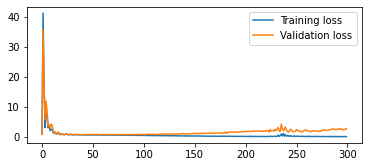

0.9541284403669725
0.9454545454545454
0.9629629629629629

0.6153846153846154
0.625
0.7142857142857143


In [11]:
model = ConvModel()
optimizer = Adam(model.parameters(), lr=0.04)
criterion = CrossEntropyLoss()
model = model.double()  
print(model)
# defining the number of epochs
n_epochs = 300
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)
    
    if not epoch % 30:
        model.eval()
        
        with torch.no_grad():
            output = model(val_x.cpu().double())

        softmax = torch.exp(output).cpu()
        prob = softmax.numpy()
        predictions = np.argmax(prob, axis=1)
        print()
        # accuracy on validation set
        print(accuracy_score(val_y, predictions))
        print(precision_score(val_y, predictions))
        print(recall_score(val_y, predictions))
    
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

with torch.no_grad():
    output = model(train_x.cpu().double())
    
softmax = torch.exp(output.cpu())
prob = softmax.numpy()
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(train_y, predictions))
print(precision_score(train_y, predictions))
print(recall_score(train_y, predictions))

with torch.no_grad():
    output = model(val_x.cpu().double())

softmax = torch.exp(output).cpu()
prob = softmax.numpy()
predictions = np.argmax(prob, axis=1)
print()
# accuracy on validation set
print(accuracy_score(val_y, predictions))
print(precision_score(val_y, predictions))
print(recall_score(val_y, predictions))

# Model Agnostic Meta-Learning

In [136]:
class MetaConvModel2(MetaModule):
    def __init__(self):
        super(MetaConvModel2, self).__init__()
        s = 100
        self.a1 = MetaSequential(
            MetaConv2d(1, 4, kernel_size=3, stride=1, padding=1),
            MetaBatchNorm2d(4),
            ReLU(inplace=True),
            Dropout2d(p=0.01),
            MaxPool2d(kernel_size=2, stride=2))
        
        self.a2 = Sequential(
            MetaConv2d(4, 4, kernel_size=3, stride=1, padding=1),
            MetaBatchNorm2d(4),
            ReLU(inplace=True),
            Dropout2d(p=0.01),
            MaxPool2d(kernel_size=2, stride=2))
        
        self.linear_layers = MetaSequential(
            MetaLinear(4 * int(s/4) * int(s/4), 2)
        )

    def forward(self, x):
        x = self.a1(x)
        x = self.a2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


class MetaConvModel(MetaModule):
    def __init__(self):
        super(MetaConvModel, self).__init__()
        self.a1 = MetaConv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.a2 = MetaBatchNorm2d(4)
        self.a3 = ReLU(inplace=True)
        self.a4 = MaxPool2d(kernel_size=2, stride=2)
        self.a5 = MetaConv2d(4, 4, kernel_size=3, stride=1, padding=1)
        self.a6 = MetaBatchNorm2d(4)
        self.a7 = ReLU(inplace=True)
        self.a8 = MaxPool2d(kernel_size=2, stride=2)

        self.linear_layers = MetaSequential(
            MetaLinear(4 * 25 * 25, 2)
        )

    def forward(self, x):
        x = self.a1(x)
        x = self.a2(x)
        x = self.a3(x)
        x = self.a4(x)
        x = self.a5(x)
        x = self.a6(x)
        x = self.a7(x)
        x = self.a8(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [163]:
model = MetaConvModel2()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

metalearner = ModelAgnosticMetaLearning(model,
                            optimizer,
                            first_order=False,
                            num_adaptation_steps=1,
                            step_size=.1,
                            loss_function=criterion,
                            device="cpu")

r = []
inner_losses = []
outer_losses = []
mean_outer_losses = []
accuracies_before = []
accuracies_after = []

for epoch in range(200):
    results = metalearner.train(e)
    if(epoch%25 == 0):
        print(results)
        print()
    r.append(results)
    inner_losses.append(results["inner_losses"])
    outer_losses.append(results["outer_losses"])
    mean_outer_losses.append(results["mean_outer_loss"])
    accuracies_before.append(results["accuracies_before"])
    accuracies_after.append(results["accuracies_after"])
#results = metalearner.evaluate(val_x)
    


{'num_tasks': 4, 'inner_losses': array([[0.8358157 , 1.1633277 , 0.85001963, 0.89663553]], dtype=float32), 'outer_losses': array([0.77183133, 0.7811213 , 0.8477668 , 0.9380575 ], dtype=float32), 'mean_outer_loss': 0.8346942067146301, 'accuracies_before': array([0.5 , 0.25, 0.5 , 0.4 ], dtype=float32), 'accuracies_after': array([0.5217391, 0.5625   , 0.5      , 0.4117647], dtype=float32), 'precision': array([0.5217391, 0.5625   , 0.5      , 0.4117647], dtype=float32), 'recall': array([1., 1., 1., 1.], dtype=float32)}

{'num_tasks': 4, 'inner_losses': array([[0.5021725 , 0.942772  , 0.51264024, 0.64176834]], dtype=float32), 'outer_losses': array([0.56314695, 0.5322894 , 0.49557555, 0.5470671 ], dtype=float32), 'mean_outer_loss': 0.5345197319984436, 'accuracies_before': array([1.  , 0.75, 0.75, 0.8 ], dtype=float32), 'accuracies_after': array([0.73913044, 0.6875    , 0.8125    , 0.7647059 ], dtype=float32), 'precision': array([0.6875    , 0.75      , 0.7777778 , 0.71428573], dtype=float32

In [165]:
for i in range(3):
    r = metalearner.train(heldout, False)

print(r)
print()

{'num_tasks': 4, 'inner_losses': array([[0.7629171 , 0.11141594, 0.51355684, 1.9627829 ]], dtype=float32), 'outer_losses': array([0.6721189 , 0.2562877 , 0.31030044, 0.79161155], dtype=float32), 'mean_outer_loss': 0.5075796842575073, 'accuracies_before': array([0.6666667, 1.       , 0.5      , 0.       ], dtype=float32), 'accuracies_after': array([0.6666667, 1.       , 0.8333333, 0.5714286], dtype=float32), 'precision': array([0.5, 1. , 0.8, 0.5], dtype=float32), 'recall': array([1.        , 1.        , 1.        , 0.33333334], dtype=float32)}

